In [1]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave
from tqdm import tqdm

import keras

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import BatchNormalization
from keras.optimizers import SGD, Adam,Adagrad
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from math import sqrt
from keras.callbacks import History 
from keras.optimizers import Adam, SGD
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, merge
from keras.layers import Activation, Dropout, Flatten, Dense,Input
from keras.layers import BatchNormalization
from keras.models import Model
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from math import sqrt
from keras.callbacks import History 
import gc

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_folder = '/home/rsk/Documents/Projects/GenericModels/UNets/train/'
masks_folder = '/home/rsk/Documents/Projects/GenericModels/UNets/train_masks'

In [3]:
fileList = os.listdir(train_folder)
maskFileList = os.listdir(masks_folder)

In [4]:
from keras.preprocessing import image

def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img


numImages = 500
imageSize = (256,256)
batchSize = 5

In [5]:
X=[]

for i in tqdm(range(numImages)):
    
    imageName = os.path.join(train_folder,fileList[i])
    maskName = os.path.join(masks_folder, fileList[i][:-4]+'_mask.gif')
    
    img = image.load_img((imageName), target_size=(256,256))
    img = image.img_to_array(img,data_format='channels_last')
    
    mask = image.load_img((maskName), target_size=(256,256))
    mask = image.img_to_array(mask,data_format='channels_last')
    
    X.append((img,mask))

100%|██████████| 500/500 [00:46<00:00, 10.84it/s]


In [52]:
np.random.shuffle(X)

In [6]:
def train_test_split(x,ratio = 0.1):
    
    np.random.shuffle(x)
    
    testSize = int(ratio*len(x))
    trainSize = len(x) - testSize
    
    trainx = []
    trainy = []
    testx = []
    testy = []
    
    for i in range(trainSize):
        trainx.append(x[i][0])
        trainy.append(x[i][1][:,:,0].reshape((256,256,1)))
        
    for i in range(trainSize,len(x)):
        testx.append(x[i][0])
        testy.append(x[i][1][:,:,0].reshape((256,256,1)))
    
    #Making masks into binary
    trainy = np.array(trainy)/255.0
    testy = np.array(testy)/255.0
    
    return(np.array(trainx),trainy,np.array(testx),testy)
    

In [7]:
trainx,trainy,testx,testy = train_test_split(X,ratio = 0.1)

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x=trainx,y=trainy,batch_size=batchSize)

test_generator = train_datagen.flow(x=testx,y=testy,batch_size=batchSize)

In [78]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model
    

## Model 1

In [9]:

inputs = Input((256,256,3))
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)


up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(pool4))
merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
# conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
# conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
# conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

model = Model(input = inputs, output = conv10)

model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    

    

/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:18: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/home/rsk/.local/lib/python2.7/site-packages/ipykernel_launcher.py

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 73856       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 128 73856       max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [13]:
testy[0].shape

(256, 256, 1)

In [32]:
epochs = 2

In [33]:
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, epsilon=1e-5, patience=3, verbose=1)

model.fit_generator(train_generator,epochs=epochs,validation_data=test_generator,callbacks = [lr_reduce],verbose=1)
 

Epoch 1/2
90/90 [==============================] - 61s 680ms/step - loss: 0.0307 - acc: 0.9878 - val_loss: 0.0381 - val_acc: 0.9849
Epoch 2/2
90/90 [==============================] - 61s 673ms/step - loss: 0.0286 - acc: 0.9887 - val_loss: 0.0356 - val_acc: 0.9864


In [42]:
pred = model.predict(testx[0:6])

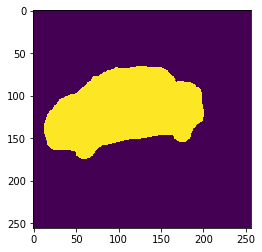

In [43]:
plt.imshow(pred[2,:,:,0])

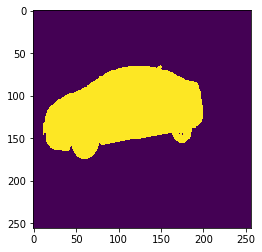

In [44]:
plt.imshow(testy[2,:,:,0])

In [40]:
model.save('unet_model1_loss_0.035_acc_0.98.hdf5')

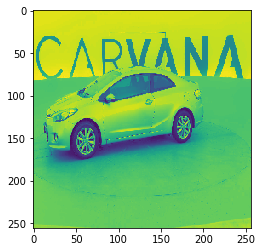

In [45]:
plt.imshow(testx[2,:,:,0])